# ETL with JupySQL

**Extract:**  

Extract means in this case to download the dataset from the Nobel Prize API.

**Transform:**  

The dataset is a JSON file with deeply nested objects.
We use in-memory DuckDB to transform the dataset into a normalized relational schema.
We store the individual tables in pandas DataFrames.

**Load:**  

In this step we load the DataFrames into a SQLite database.

Required Python libraries:

In [ ]:
%pip install -U duckdb duckdb-engine jupysql --quiet

## Extract

We download relevant data from [https://www.nobelprize.org/about/developer-zone-2/](https://www.nobelprize.org/about/developer-zone-2/).

OpenAPI: [https://app.swaggerhub.com/apis/NobelMedia/NobelMasterData/2.1](https://app.swaggerhub.com/apis/NobelMedia/NobelMasterData/2.1)

In [2]:
RAW_LAUREATES_FILE = 'work/data/nobel-laureates.json'  # adapt to your path
API_URL = "https://api.nobelprize.org/2.1"

![[ -f "{RAW_LAUREATES_FILE}" ]] || wget -O {RAW_LAUREATES_FILE} {API_URL}/laureates?offset=0\&limit=2000

## Transform

First, we load the JupySQL extension and connect to the in-memory DuckDB database:

In [3]:
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [4]:
%sql duckdb:// --alias duckdb

### JSON structure of the dataset

In [5]:
import json
import pprint

with open(RAW_LAUREATES_FILE) as f:
    data = json.load(f)['laureates'][0]
    pprint.pprint(data, sort_dicts=False, compact=True, width=160)

{'id': '745',
 'knownName': {'en': 'A. Michael Spence', 'se': 'A. Michael Spence'},
 'givenName': {'en': 'A. Michael', 'se': 'A. Michael'},
 'familyName': {'en': 'Spence', 'se': 'Spence'},
 'fullName': {'en': 'A. Michael Spence', 'se': 'A. Michael Spence'},
 'fileName': 'spence',
 'gender': 'male',
 'birth': {'date': '1943-00-00',
           'place': {'city': {'en': 'Montclair, NJ', 'no': 'Montclair, NJ', 'se': 'Montclair, NJ'},
                     'country': {'en': 'USA', 'no': 'USA', 'se': 'USA'},
                     'cityNow': {'en': 'Montclair, NJ',
                                 'no': 'Montclair, NJ',
                                 'se': 'Montclair, NJ',
                                 'sameAs': ['https://www.wikidata.org/wiki/Q678437', 'https://www.wikipedia.org/wiki/Montclair,_New_Jersey']},
                     'countryNow': {'en': 'USA', 'no': 'USA', 'se': 'USA', 'sameAs': ['https://www.wikidata.org/wiki/Q30']},
                     'continent': {'en': 'North America', 

### Desired relational schema

The goal is to normalize this dataset to correspond to the following relational schema:

```mermaid
---
title: Relational Schema
---
erDiagram
    LAUREATE ||--|{ PRIZE : receives
    PRIZE }|--|| PRIZE-CATEGORY : "belongs to"
    PRIZE ||..o{ INSTITUTION-PRIZE : ""
    INSTITUTION ||..|{ INSTITUTION-PRIZE : ""
```

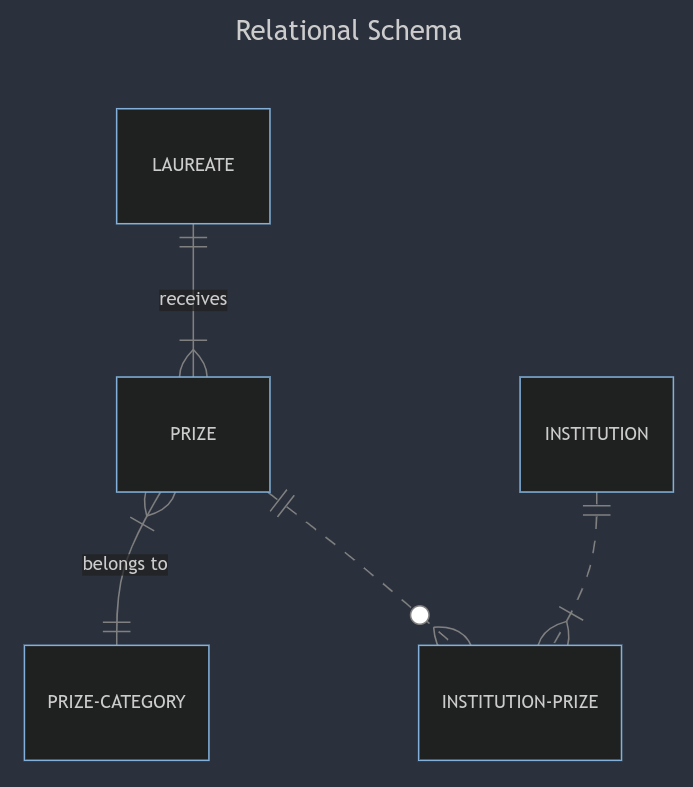

In [6]:
from IPython import display
from base64 import b64decode
display.Image(b64decode("iVBORw0KGgoAAAANSUhEUgAAArUAAAMTCAIAAAAw8HhRAAAACXBIWXMAAA7EAAAOxAGVKw4bAABZJ0lEQVR42uzd91NT+5/48e9/srfovTZEeu+9F+m99w6BBEiC5arXrtfe27Xca0fFiqggIG77bWd/393ZndnZnf1pZ3/5fF/w1vOJCYSAIASemcc4cHII4W2S9/MkJyf/b8OWQAAAAEv/jyEAAAD0AQAAoA8AAAB9AAAA6AMAAEAfAAAA+gAAANAHAACAPgAAAPQBAACgDwAAAH0AAADoAwAAQB8AAAD6AAAA0AcAAIA+YBQAAAB9AAAA6ANg3gy92z9OnXwCY1bnCFy+el3+/AcPHy3VFWjT9ar/gpDIZG6QAH0AzEFZZeNHi9PExMTw8MjjJwOnzlyoqGlx8QhZJn2wyT14prOq69vevhs+f/HKZs/QFdAHRWV1Fy9dG3rz5sPU/8XD/scHDx9PSM2jDwD6AFiyPrA6ydw276llofogu6Di5Onzpm27Z1rh/oN+9YvSs4qdug+kgQ7/dnLa/4jbd+7TBwB9ACxBH5w9f0mnN4ltO369cOnq2NiYWt7/6PH8nkVYkD6QKVNdyI5d+2ZaR86SFV68fOUVEO3UfaDv2ab+2MHB193GHRU1LW2dvWfPXZL/C53BTB8A9AGwBH0gX1guDwpPetj/eNqzllsfiOiETA/fSKfe/2CjW9DroTey/ps3b/1D4i3P8guO8w2KpQ8A+gBY+j4Q+cU16qw9+w4v8z5YAfsnyhSu/tKDh4+zfyJAHwDLtw8i47aqs06cOme53MUjpLGl68bNP9++Gx4dG3v67Pmxk2fTs0sc74Og8CRj3y9/3rk3PDwyOjr2/MXLs+cvFZXVWa125tylaV+M7zHtVCucOnNBW/hk4KntX1dcXn/h0tXB10NjY2OvBl/LBUr0TDuJqstMzyo+f/GKbMfL+o+fDJi27XbzCZ/flZ9rHwSEJag/ZNevBx38v5Nrsm3n3jt3H7x581ausIzAvgNHk9MLpu2D7IIKGQpZ8/3o6N17D5raDDPt8plTUCl/0eDg6/HxcflXfqq6vs1qZXXJ7Z1GtUPlzT9uv3//Xm4Pf96+K2epleVyZDCH3ryRG8n9B/0dXaaNbkHzHkyAPgCWSx/IlK/O+nX/EW1hYHiizC7TTtv7Dx2znABm6oOE1DyZCaa9BKtN56/pA1fP0NNnL07748dOnLHco0JNdQMDzypqWj58+GC18s1bty2nRsev/Fz7QH6LTLHqmthGia3mNoO2j4jVqbWjx6oPDh05Ybva4d9OWl2mDNpvx09Pe5lSAL7BcVaDJmko/xe2K1+6fE3Syna5VWjOaTAB+gBYLn2gTSoFJZ+2uT39ox49HpAlMo/uPXBENhBTMgprGtrv3X+o1pTN2Vn7QCbC/kdPZEvxl90H5Gcra1qMfbvUS+9yki1+bU2ZJr0DYj69xrH3kPx2xfXz+xhDolJkjrl2/ZZtHxw9dkr9oGzCZuaWhcekybVVE7acdu7eb7uRLX+U/CFyldKziusaO549f6GW1zXp5nHl57F/ogSWdp3t73CgXWfZOjf07pA/MC2ruL6588rVGy9fDcqgWa0mJ+1Pa2nvfvPmrdX/rHL85Fm1/MKlqyUVDSlbC2VTXqs0SQSt/ywv+drvN/OLa7Lyys3bd49aJIv84TI+Upltnb1v375TCy2fv5nTYAL0AbA0fdDY0iXzsUwAXgHR8piubUf+8eddbQNaTWATExP5X84rrl6h12/8oaZY7aVuO68vRCdkun55rILgiOSRkfdqZprr/gdqArPsg4zcUvVTJ0+ft3xKQ76+dOV39SeERadZTXWHj56wfF4hMCxRbd3KND+/Kz/XPvAPideiZHh4pG/HHstNdo1cc/U8h/zJciWtzrUMC+1PO3LslOWfFpOYpS5BQkRbWFHTolbe/steq8uUJeqsytoWq0s+cPiY5fMr0lWfc6Tf3TfC9n/kyG+n5jeYAH0ALE0fTHt69HggICxB24teTSr7Dhy1vZy45Gz1IzJzzG//xBOnzsnKsvn49X2gXnf4MDGhXXlNUnq+ukDtgAp2duKTzXH1bsP5Xfl5HB9JBtnyZREJlD37DltVwq/7j3w63oPNPh+O75+ortvg6yFtiTqMhFxb2/0SZAqXQZBzZajtX7L0ilreaeizupDnz1/K8lt/3JnfYAL0AbAs+kBmJn3PNstNwKraVnVWVl75tG/PU5t9+w/+5kgfyOasbLDK9r0kiMxSMjn1P3qituwt56f59cHQm8nnqG/c+nPa9d8ND8u5V6/dmHUSVc+XjI+Pz+/Kz/v4ygmpeXLh2s4Q8udYHvpp4OlzlW5f8/4FyQ71fI96fiUwPNEqm6ycv3jF8pfOdMnyfz1TH6hnmGSs5jeYAH0ALE0fyMSQmVsmtNebrV6c3rZz70cHTtoTyPZfX5BZc6ZLsHzCeR594OkfZX8fN7V/5eMnA7NOort+PajOmt+V/8rPX4iKz7hw6aq62LfvhgNCJ58L2eIVppb8dvz01/SBOqiUnLT3Gjjyn/vixat598G0o+H4YAL0AbDE+yfKPDQ8PCJLnj1/Ybkj/f6Dv2lH97Ojq3ub/T4Ii05T2/ejY2O95l8iYtM3e4b6BsdpexR+ZR9obxTcs/fQtOvf/OO2nPvq86sGdibRX/YcsOqDOV35Bfl8Ji3LjH2/WD6BP9NfN78+KK9u/hQib9/Z+c89d/7yAvbBnAYToA+ApX//Qnun0fb9CNpkqTZkZzVTH5y7cEU9aZ+aWfTFRLjj14V5/sAv0v7zB2qDddanyqftgzld+QXpA7lA9XaDm7duWz47cujIiQXsg8LSWvWthIIj12pB+mBOgwnQB8DS94HMGWoS/fDhQ3RCplrY2tGj1szMLZt3H7j7RnyYmLDcTcHBPti5a7/j+x+oCfXa7zen3e9BvSvh0uVrc+2DuV75hfp85z9v31VP56j9PNR7BWXhAvZBbFL252cpdn2bPpjrYAL0AbD0fbBh6kiCavmNm3+qXdi0wykeOXbKkUvWPm0oNCpVWxgek6YWNrUZHOyDialZ5PDRE473wdnzl9Sz1rYfylBQ8umg0ZIvc+2DuV559V5K7TX7+dnsGfr23bD6oCzLd2fIsETFZyxUH8h/8aupdygMDDxzZK/Ar++DuQ4mQB8Ay6IPNlgcYqi2oUMtuXjpmpqZKmtarFZ28wmXR3zLJfXNnZ/e8djZqy30CohW873Vy+dB4Unq/W9y8vT7YlJ/+WpQHapvpnnLtg+0T46wPA6S2mbVnhcJDE+cax/M9cof+3y4oYSUXEf+L+JTcipqWiz/TBePEG23D+2Xbs35dCyBO3cfaIdC0mTlV8yjD4TM6GrJvgNHrYZa6iE2KXth+2AetwSAPgCWRR/4BceptwIOvXmjXiMIiUrRDm938vT54vL65PQCmZB6TDtlK/nuvQeW80pEbLqaAGQy3r33kDbBXL02eVCBsbGxpla9zC7BEclSEoOvh7S91q3e1r/3wBHtqL0y8cu5Xd3bLFvEtg+0lFFHEZYfkU3torI67cjQveZfHJlEbfc/mNOVr2vSqYUyaIbe7bN+BuPhoyfU7p9Hjp2SIZWJUx2tUn2oo+VuHwcOfzrS4qupT4LOzC1L3lpQ09Cu3kOovRlyTn3g6hV649afauGft+/WNXakZBTKRcn2vXz7/v17ragWav+Dud4SAPoAWBZ9sOHLA/irJTLNa8f4szrJxGY1W2jvD7R8Pj8ybqt2tF3t9H50VKY3+Ve9Rd7ydQHf4DiJD6v1LXejm7YPPP2jbtz8c9rrabV9PKc+mNOVlxlX7TqgTlZ74U3zOoLNJauTDHh8So7VXhRaItie5GrPow+Ed0CMmrNtTzKLW77fdUH6YK63BIA+AJZLH2x0C1KfrTAxMaFtlbr7RugMZpn5Jj9zb2xMJu9z5y83NHdN+6lCVbWt167fkmlA37PNci+EU2cuyI/LNCCbyHv2HVbTTFZe+c0/bsvyiNh0ywuRLddjJ868Gx6WWUq2xW/9ccdyrpq2D9SVl5nmytUbsvE9Pj7+8tWg/FLbgzvNqQ/meuW3eIfL9v3dew9k+1s2x+3/X4REpWzbuVdWlgv58OHD0Js3MnRy9SyPUvXFPiLZJTIsz1+8lL9uZOR9/6MnR46dyiuqsv2UBAf7QO3wIe116crvatCk+a7f+EP+BMsnDzYs3PEP5npLAOgDAABAHwAAAPoAAADQBwAAgD4AAAD0AQAAAH0AAADoAwAAQB8AAAD6AAAA0AcAAIA+AAAA9AEAAKAPAAAAfQAAAOgDAABAHwAAAPoAAADQBwAAgD4AAAD0AQAAoA8AAADoAwAAQB8AAAD6AAAA0AcAAIA+AAAA9AEAAKAPAAAAfQAAAOgDAABAHwAAAPoAAADQBwAAgD4AAAD0AQAAoA8AAAB9AAAA6AOGAAAA0AcAAIA+AAAA9AEAAKAPAAAAfQAAAOgDAABAHwAAAPoAAADQBwAAgD4AAAD0AQAAoA8AAAB9AAAA6AMAAEAfAAAA+oBRAAAA9AEAAKAPAAAAfQAAAOgDAABAHwAAAPoAAADQBwAAgD4AAAD0AQAAoA8AAAB9AAAA6AMAAEAfwAGbvcOxwnCrBkAf4Gt5BCVuv//PWDHqDtzlVg2APsDC9EFKVQ9WgOZjT+gDAPQBFqwP4ota/+a77+Ds6AMA9AHoA9AHAOgDRoE+AH0AAPQBfQD6AADoA/oA9AEA0Af0AegDAKAP6APQBwBAH9AHoA8AgD6gD0AfAAB9QB+APgAA+oA+AH0AAPQBfQD6AADoA/oA9AEA0AegD+gDAKAPQB/QBwBAH4A+oA8AgD4AfUAf0AcA6APQB6APANAHoA9AHwAAfUAfgD4AAPqAPgB9AAD0AX0A+gAA6AP6APQBANAH9AHoAwCgD+gD0AcAQB/QB6APAIA+oA9AHwAAfUAfgD4AAPqAPgB9AAD0AegD+gAA6APQB/QBANAHoA/oAwCgD0Af0Af0AQD6APQB6AMA9AHoA9AHAEAf0AegDwCAPqAPQB8AAH1AH4A+AAD6gD4AfQAA9AF9APoAAOgD+gD0AQDQB/QB6AMAoA/oA9AHAEAf0AegDwCAPqAPQB8AAH0A+oA+AAD6APQBfQAA9AGctg+ysrMNBsMSXoHNrq6XL1+mDwCAPqAPvoXKqqqPHz+Wl5fbX+3U6dNPnjyxWugfECA/e/DgQavl586dk+UbNm6UrzOzsj5+Po2OjsqF7N+/38/fX1v5yJEjH6c7RUREWF5mY1PTxMSEl7e3+vbhw4cfZz7pOjvVdbM9nT59mj4AAPqAPliAPnDdsmV8fFxWi46JmV8f3Lt3T1Y7eerU06dP5dvh4WEtEVQfyLR95MuTt4+P5WXKJchqbe3t6luz2aytqS7T8hJycnLUdRsYGLC62ObmZvoAAOgD+mAB+kDmVLXxvWPHjvn1QfvneV0YTSZZsm37dss+8PX1tXMFIiIj1RWQSrA9d9pLmOm68foCANAH9MHC9MGDBw8ePXp0586dwcHBH3744Sv7IDomRpYc/e03x/tg9+7dExMTJ06ckDVDQkPpAwCgD+iDJe4DNZ3rDYbOri75IjUt7Sv7QF1OS2urg32w9qef3r59e/XatYTERFmz12ikDwCAPqAPlrgPfv31V1khMChINtytZlzH++DGjRs9vb07du6UaX5iYuLO3bs/r1s30/6JljEhioqKZGFNbe33P/zw+vXrZ8+efff99w72geXpw4cP9AEA0Af0wQL0wU8//zw8PCzTufr2yZMn74aHZeH83r+gTn3btq3fsMFqdpcKMX0+JSUnW17axYsXZWrf7OoqX+/bt09WjouPd7AP7t+/r12s7RMP9AEA0Af0wXz6oLikRM5tbWtT3/b19cm3+QUF83t9IS8vT74+dOjQrLO7xsvbe2Ji4vz58+rbjMxMWXnX7t28vgAA9AF9sGR9cOXKFXUoApepk5rstUMI+Pn7y7eHDx+2+qnzFy7IcvUkgdX+B5cvX7Z6AsB+H6idFeobGtQVcPfwGB0dHRoa+nHNGvoAAOgD+mAJ+sDH11e23W0PMTQ+Pr7JxUVWcHN3l2//+OMPqx8cGBj48OGDeqeDVR8EBwfLWXfv3dPeB2GnD777/nu5qGkPc5SRkUEfAAB9QB8sQR8YDAY5a3KHAIuT2l2xqrpaSwH5trqmRvupltZWWXLl6lX1re37F3bs2KGeEpi1D+TXyVkXLl60vAK1tbWy8MjRo/QBANAH9MHi9sHNW7esjjMYFR397NkzbcdAjXoXw9Vr19S3ubm56jmGu/funTx1qr+/X74eGRnRjo5s2wcbN20afP363bt3rlu22Dl+4voNGw4fPixnZefkWF6B73/4QX78/fv3Vu+AmLYPbI+fWDbbkaTpAwCgD+iDT31ge9Lr9fKvtmOgpYf9/dIEnl5e6tvEpKSzZ88ODQ2Nj4+/fPlSJvWAwEBtZds+EBWVlbLwwNTG/Uyfv+Dr5zc6OioZsWbtWuvDJe3ZIysUFxfP6f2N6rT7y30b6QMAoA/oA/D6AgDQB/QB6AMAoA/oA9AHAEAf0AegDwCAPqAPQB8AAH1AH4A+AAD6APQBfQAA9AHoA/oAAOgD0Af0AQDQB6AP6AP6AAB9APoA9AEA+gD0AegDAKAP6APQBwBAH9AHoA8AgD6gD0AfAAB9QB+APgAA+oA+AH0AAPQBfQD6AADoA/oA9AEA0Af0AegDAKAP6APQBwBAH9AHoA8AgD6gD+gD+gAA6APQB/QBANAHoA/oAwCgD0Af0AfcsAHQB6APQB8AoA9AH4A+AAD6gD4AfQAA9AF9APoAAOgD+gD0AQDQB/QB6AMAoA/oA9AHAEAf0AegDwCAPqAPQB8AAH1AH4A+AAD6gD4AfQAA9AF9APoAAOgD+oA+oA8AgD4AfUAfAAB9APqAPgAA+gD0AX0AAPQB6APQBwDoA9AHoA8AgD6gD0AfAAB9QB+APgAA+oA+AH0AAPQBfQD6AADoA/oA9AEA0Af0AegDAKAP6APQBwBAH6zMPlizbgOcHX0AgD7AQvYBVgz6AAB9gIXpg4ymPSte7bZT207+mdO6bzX8sdyqAdAHgEPSMvL7+vrcvMMYCgCgDwD6AADoA4A+AAD6AKAPAIA+AOgDAAB9APoAAEAfgD4AANAHoA8AAPQB6AMAAH0A+gAAQB+APgAA0AdYal7+USGRSbMqLKmQPoiKS3Nk5U3uwQwsANAHcGIZ2YV9C33y9ItkYAGAPgDPH/D8AQDQB2D/AwAAfQDQBwBAHwD0AQDQBwB9AAD0AUAfAADoA9AHAAD6APQBAIA+wLxxfCQAoA8AayERiZk5RbOqqWuUiT8nv9SRlV29QhlYAKAPwOsLAAD6APQBAIA+AOgDAKAPAPoAAOgDgD4AAPoAoA8AAPQB6AMAAH0A+gAAQB+APgAA0AegDwAA9AHoAwAAfQD6AABAH4A+AADQB6APAAD0AegDAAB9APoAAEAfgD4AANAHoA8AAPQB6AP6AADoA4A+AAD6AKAPAIA+AOgDAAB9APoAAEAfgD4AANAHoA8AAPQB6AMAAH0A+gAAQB+APgAA0AegDwAA9AHoAwAAfQD6AABAH4A+AADQB6APAAD0AegDAAB9APqAPgAA+gCgDwCAPgDoAwCgDwD6AADoA4YA9AEAgD4AfQAAoA9AHwAA6ANoft7ktdiiYhJrampctvh9g9/FfygA0AdYAGt+2vjjmnWLarOrW2Bg4Nqf1i/2L/p5owf/oQBAH4A+oA8AgD7AiuiDwqLS4eHhjMwc+gAA6APQB5/6oL6h6ePHj+UVVfQBANAHcKY+WLN2/aK+vuDp7cfrCwBAH2BZ90F1Tb1s0OcXFv+ya8/r16/l69DwqMkZd+36xqaWBw8ejo2NvXo1ePjIUf+AEMuGqKyquXnz1vDU6cLFS9k5eZ/O/fIHjx8/kZqaqvpA1v84dUpITPlp3UY59/mLFz9a5IhcDTm3vqFJfbs1I/v69RvvR0ffvXt38dLl5NR0bc2m5tZHjx6/f/++v//Rtm071m1woQ8AgD7AAvfBwMDAmTNnCwpLZN5VE/Chw0dk+dWr1/SGnv37D8pkPzQ05OcfrM49ePCwnHvv3n2TuW/7jl/u3r0neTHtD46Pj799+zYgcLItSkrLz52/oPpAvu01muTrtPRMbdY/e/ac1MamzW7ydXVN3cTEhESArLZt+06JCfk2L79Q7cQgP3j//oPOLoOEy9Nnz6RX6AMAoA+wwH0gW/aW2/F5BUWyUGZlbUlK2laZng8dOjK5lV8wuZUvPfHTuo3a0wnqa9sfzMnJm/zBw0fUt+0dOq0PfPwC5SyZ4NVZHl6+Hz58UJ3h5eM/Ojp6/fqNdRtc1Lnunj6Dg4OSAvK1FIlcSGJS6ueXMDx4fQEA6AMsfB/U1DZYvpYvc7/M3G4e3jI9ax48eDjw9Kmce+7cefmR4JBw250AbH/Q09P78ePHT6d+0KoP1PrvR0fVEwZt7ZNnBYdGyNctre3ydW5egeUV2L3nV1no6xdUUlouXxw/cdLF1Z39DwCAPsBi9UFWdq7lNC8d8HG607Pnz9W5w8PD0+4kONMPPp/6Qds+yMzKlW8rq2rka+mPS5evqOUHDhz6OMPJPyBkzdr127bvlBB59+5dr9GkKoE+AAD6AAvcB5lZXxyQ4PmLF1IAsXGJVtSui3Lumzdvpu0D2x9MS9taUFAQHhE9bR/8uHb9wMDA1avX4uKT1BMGljsxlJSW216HNT9tUOuER8acPHVaVnv8+LGbuxd9AAD0ARa3D65cvSoLPbx8p40Amc7lXC8ff9uzbH/Q6v2N1n0wtWRiYuLCxUuTuxl+nvu79N2yWlFx2axva9R16mXNDl0XfQAA9AEWtw+qqmtl4eEjR7UJWzb03T191Ne1dQ3q3LU/f9o/8ad1m7x9A6b9Qdct7vHx8Xb6QDb9x8bGZKGcpS0MDgmXaOjvf+Sy2d32wAmbNrv5+gWpr5NT0+Vn+/q20wcAQB9gcftAZvczZ87K8tt37pjMfdu277x7994ff95Wh06SLLh46bJ6f+O2bTvk3EePHqtdB2x/8P79B/fv3//p5w0z9YGQnhgdHZVQsFyodld8+fLVzl929xpNFy5eGh4eVokg11nWl58ydPfKr5aSkEqgDwCAPsDi9oGKgA5dp8y+snH/+vVrmfUzs/66D+NP6zZ2dhnUuc9fvJDJWx2ZwPYHz1+4UF1dbef5A5GYlHrw4GHb1w7yCopu3fpDUkDK4Pr1G/UNTeoZi/iEZLk+r14NDo+M/Hn7TkFhCfsnAgB9gIXsAz6/EQBAH4A+AADQB6APAAD0AegDAAB9APqAPgAA+gD0AX0AAPQBFtX6zf6LLSk1S6/Xu3oGf4PfxX8oANAHcA5pGfl9fX1u3mEMBQDQBwB9AAD0AUAfAAB9ANAHAEAfAPQBAIA+AH0AAKAPQB8AAOgD0AcAAPoA9AEAgD4AfQAAoA9AHwAA6APQBwAA+gD0AQCAPgB9AACgD0AfAADoA9AHAAD6APQBowEA9AFAHwAAfQDQBwBAHwD0AQDQBwB9AACgD0AfAADoA9AHAAD6APQBAIA+AH0AAKAPQB8AAOgD0AcAAPoASyskIjEzp2hWNXWN0gc5+aWOrOzqFcrAAgB9ACeWkV3Yt9AnT79IBhYA6APw+gIAgD4AfQAAoA8A+gAA6AOAPgAA+gCgDwCAPgDoAwAAfQD6AABAH4A+AADQB1hsLa3t0gexiRkMBQDQB8CknLwSdWDEXqMxMDSeAQEA+gCrXWJKtpRBXX2T/KvTdRm6e7z8OXwyANAHWMXCo1PMZnNVTX1aRp70QUBonPRBe0fnFnZEAAD6AKuT1IDRZGpobNnkHqztnxgQGt9rNDY0TS5kiACAPsDq4ukXaejubmvXqQ9rtnz/QkRsqtlsLquoYZQAgD7AKiJN0KHr1OsNHr4RaonV+xuT03Lk25z8EsYKAOgDrBYVVXW9vUa/4Fhtie3xD/IKymRJSGQSwwUA9AFWxT6JMvEnpmZbLrTtg41uQc0tbR26rs0eIQwaANAHWMlksu/s0je1tMn0b78PhH9IrNlszsnjVQYAoA+wouUVlJnMZstXFuz0gcgvKp92fQAAfYAVIiA0TiZ7SQTbs2bqA1evUL2h2/b5BgAAfYCVQCb41rYOmeyn3Z/AzuczRceny1nJ6bmMIQDQB1hpUqeOkBgVnz7tufY/v7G6tqG31+juE84wAgB9gJVjk3twd09vTW3jTCvY7wNP/8heozG3oJSRBAD6ACtH1NRrBEHhCfPrA1FYXKE3dLMXAgDQB1g5qqrrdbouOyvM2gfBEYmyQmRcGoMJAPQBVgKZ9c1mc1Zu8df0gejqMlRU1TGeAEAfYCVQc79XQNRX9oEUhslkUp/nBACgD+Dc2js6m1vaHGkI+30ghSHrpG7NY0gBgD6AcwsIjXdkUnekD4R0RktrO6MKAPQBVsKLCwGhcQvSB7kFpbIaLzEAAH0A51ZQXDE5o3uGLkgfJKflyGr+IXEMLADQB3Bi1bUN3d09Dj7NMGsfhE19NnQU73IEAPoATq2tXTfrzomO94F3QPTk3gwZ7KIIAPQBnJnRaCqvrF2oPtjoFmQ2m/OLyhlYAKAP4KzcfSNk1s/JL1moPhA6XVdVdT1jCwD0warmEZRYd/C+k2r57dG2q287Tj6ddU3dqaeyZsPhh7Ou2XP+lfHia+cdk7oDd7lVYzWo2n3Die+nsOETvpU+WHZ9sP3+Pzf99thJNR970nRsYS9w6jKddjToA6yePmg/+9p5H7tgSaYh+mCZ9kF8UevffPcdnB19gNXWB9zrV4ConBr6gD4AfQDQB6AP6APQBwB9APqAPgB9ANAHoA/oA9AHAH0A+oA+AH0A0AegD+gD0AcAfQD6gD4AfQDQB6APQB/QBwB9APoA9AF9ANAHoA9AH9AHAH0A+gD0AX1AH4A+AH0A+gD0AegD0AegD0AfAPQBfUAf0AegDwD6gD6gD+gD0AcAfUAf0Af0AegDgD6gD+gD+gD0AUAfgD6gD0AfAPQB6AP6APQBQB+APqAPQB8A9AHoA/oA9AFAH4A+oA9AHwD0AegD+gD0AUAfgD4AfUAfAPQB6APQB/QBQB+APgB9QB8A9AHoA9AH9AG3atAHoA9AH4A+AH0A+gD0AegDgD6gD+gD+gD0AUAf0Af0AX0A+gCgD+gD+oA+AH0A0Af0AX1AH4A+AOgD0Af0AegDgD4AfUAfgD4A6APQB/QB6AOAPgB9QB+APgDoA9AH9AHoA4A+AH1AH4A+AOgD0Af0AX1AHwD0AegD0Af0AUAfgD4AfUAfAPQB6APQB/QBN2zQB6APQB+APgB9APoA9AHoA4A+oA/oA/oA9AFAH9AH9AF9APoAoA/oA/qAPgB9ANAH9AF9QB/MR2VV1cep0/j4+ODg4JWrV5ubm9etX6/O3bBx48fPpw8fPrx69er06dMpqanaj7tu2SJnyUL17bVr1z5OdwoJDZVz/QMCpj1X+3H6AFh5fbB79265m0dERKhvjxw5Ultba7VOTk6OrFNSWqq+jY6JuXDhwtDQ0NjY2KNHjwwGgyzMy8//aPekrdPU1KT93plOV65cUVdGvvb19f1iWo2OloV927apxzc7p/iEBFn/4cOHw8PDlpfgsnnzjh07nj59KtdfHjZPnjqVlJxsuYIjg0Af0AfLog9u3rq1/8CBs2fPvnnzRr59/PjxZldXrQ8GX78+dOjQsWPHbt++re4VBYWF0/aBrrPziMVJ7oFy7rlz59S5qg8GBgaOfHmSIqEPgNXTB6Ojo6FhYTNNjXHx8bK5MjIycvDgQVlZ+uDU1COMRIP2oHHmzBnbBxOrPigrL9fOkoc49UCnLdHpdLP2wfoNGywvX672+/fvLZcEBgXZ9oGXt/ez58/lEuQB8+hvv8lWk/w58m1be7tlH9gfBPqAPlgufVBeXq6+XbN2raSAum9ofSAhr62fvnWrLLlz5860fWBF7t5ybvjnxwXVB7KQ1xeA1dwH8m1/f/+6deumnRplU0S+TkpK0s7d5OJidZkzPZhY9oGdBzrLedpOH1it/OrVq2fPntn+gZZ98N333//+++8TExOlZWXaCgGBgZIysjAuLs7BQaAP6INl1wfC189Pe/LNtg/k1i/ZOzg4OGsfSFl/+PBB7uqz3qXpA2C19cHIyMgBi4cCy6nx0qVL8vXGTZvsXOay7YOk5GTLJ001qWlpsvzkqVMODgJ9QB8sxz4ICQ2VJWfOnJm2DxISEy1v/Xb64Pjx49IH6vk3+gCgDyynxoqKCvm3uKTEdmo0mkzydUtLizP2gfyU/KxcDat1ZMtqaGjo3fDw9z/84Mgg0Af0wbLrg3Xr16sX9tSdU/XBs+fP5R7b19cn8Ts6OvrmzRu1v6GdPpDHAll+4Mt7r+3+iRIQ9AGwCvtg3bp1+/btk2nV18/Pamrc7Or6sL9fbaXExMY6Vx+cP3/e8o+19Pvvv8tZ8pjpyCDQB/TBcumDu/fuHTt27PLly3JLlW/v3bv389SrYpbvX1CnCxcvWt6XZuqDc+fOjY+Pe/v42N6l79+/b/p86jUa6QNgdfaBPMj09/ffvn17zdq1VlOjnGUwGN6+fSsLL126pKZPp+gD9R4uny8vUJEHT+0sRwaBPqAPlkUfjIyMyKa83MTv3LnTpddbvb9Rvb7g6eX1/v37x48fy+3Yfh/ExcXJQnlQcPAuTR8Aq7AP5OvQsLCxsbEdO3ZMOzXKA1FnZ6dsabx8+dJl82an6AP1/Ou0T3uo91CoP8TxQaAP6INltP+BJav9D3SdnfKtel+QnT64cvXq6Oiou4cHfQDQB3b6QNQ3NKiHhZmmxrq6OjlLVlvEPvjy+YnomJjJPujrm0cfqJ0nqmtqrNaRzSpZ5/Xr1/MbBPqAPljufbD2p58GBgbev3/v5e09Ux+kpKbKErPZ7PhLhvQBsGr7QMgDiHr5ctqpUW3N79i5czH6YPeePbI8IyPDcmFpWZks7OzqmkcfxCckqCMfWK0jf5osP3To0PwGgT6gD5Z7H2h70Jw8eXKmPrh569a74WGrJwPpA4A+mGlqdHFxefHiheX+idqBg777/vtdu3bZTvkL1QcqBe7cvauOCCfc3d0fPXokCxMtDsAw1+MfWD3PGhMbOzQ0ND4+rv1dsw4CfUAfOF8fiItTe9mkpqXZ9kFWdrZ6v4PVERJVns90/MSyGX47fQCshj4QMhl/+PBBTY3t7e1qL+mTp071T72RYfI4Qp93ilrYPlizdu0ff/whZ7179+78hQuXLl0aGRmRb4/+9pvtH+JIHwgfX9+XL1/Khcjy48ePyybTxNTJ8kWHWQeBPqAPnLIPAoOCJIT7Hz2Su5ZVH9y4cWPao5S3tLba+fwF2z0Z6QNgVfWBMBgMamqMT0g4e/asTMYyVUsl6A2G9Rs2LNL7F9R7Jbq7u2UuV4dP/vPPP2tra9VRCubXB2rDadeuXbKlJA+V8lMnTpyI/XKPxVkHgT6gD8DrC8AK7wPw+Y2gD+gDgD4AfQD6gD4A6APQB6AP6AOAPgB9APoA9AHoA9AHoA9AH4A+oA/oA/qAPgB9ANAH9AF9QB+APgDoA/qAPqAPQB8A9AF9QB/QB6APAPoA9AF9APoAoA9AH9AHoA8A+gD0AX0A+gCgD0Af0AegDwD6APQBfQD6AKAPQB/QB6APAPoA9AF9QB/QBwB9APoA9AF9ANAHoA9AH9AHAH0A+gD0AX0A0AegD0AfgD4AfQD6APQB6APQB/QBfUAf0AegDwD6gD6gD+gD0AcAfUAf0Af0AegDgD6gD+gD+gD0AUAfgD6gD0AfAPQB6AP6APQBQB+APqAPQB8A9AHoA/oA9AFAH4A+oA9AHwD0AegD+gD0AUAfgD6gD+gD+gCgD0AfgD6gDwD6APQB6AP6AKAPQB+APqAPAPoA9AHoA9AHoA9AH4A+AH0A+oA+oA/oA/oA9AFAH9AH9AF9APoAoA/oA/qAPgB9ANAH9AF9QB+APgDoA9AH9AHoA4A+AH1AH4A+AOgD0Af0AegDgD4AfUAfgD4A6APQB/QB6AOAPgB9QB+APgDoA9AH9AG3UfoAoA9AH4A+oA8C3bzD6xqauReAPgB9APqAPvhko1tQfUOz2WwODk/kjgD6APQBpumDmn1/YAWYUx9k5Rb39fWlZeRzL4Dz9gH3+pWBPlimfdBy4tkieL7t+mjn2UFHVu659MZ0ZVh35pUjK5uujJivjSzOdXZi3RffyIAbLrxxsA/ColPMZnNVdT13AThvH6yGu7bcr/UXhlbDX0ofrBYhkUmybRoYGj/rmlFxabJmSXm1IxfrFxwrKxeWVDDCti8WVFbXy+DIvx5+EfZX9vSL7Onp7dB1bvYMYeiA5Uzu1Jk5RYwDfbByJKflyM3akemntr7JaDJ5B0Q7crFFpVVysb5BMYzwtDKyC2V8Wts6wqJTZlpnk3twU3Or0WhkGAH6gD7At1ZQXKE3dM+eEem5cuvfmlXgyGW6eITIrFZb18jw2hERk9rbazSbzalb86b/rykqlzGPTcyY6RKk6jp0ndl5xQwmQB/QB1hg9Y0ts75xzs0nvL1DJxu7jj4nMRUTMv8xvLO9azGsvqF58oWYYusXYqLj02V5flG5vZd1p16niIxLYyQB+oA+wALr6ektKqm0v45socpNPybB0X1SpCR0uq6NbkEMryPyCspkeCXU3H0/7Y7gGxRjNBqbWtrsjGFaRr78VE5+KQMI0Af0ARb6PRG+EbO+cc4/JFYaoryy1sHLDI9OkctMTs9leB0Xm5ghg2bo7gmJTHLxmHzVwNDd7ekXOdP6weGJZrO5vqGZCAPoA/oAC0+2U+U2nZiabWedkvJqB9/gMPWEebheb2hpbd/kHszwzol3QHRrW0d6Zn5FVZ3M/RIKM63p7hshgyxktBk3gD6gD7DwZAtVbtOpGXkzrRAZmyorZOeVOHJp6jB/RqPRyz+SsZ0f+b+QAU+feT9QGeSGphaOpQjQB/QBFtEW7zC5TWdkF860Qm19U3tHp6zmyKWp9+w5vpsCrASGxptMJvuHQlI7K6Tw8g1AH9AHWDwuHsFTTw9M/wa5xNTsyVcfUrIcuSj1inhRaRWjOj+uXqGdXXr7h0JSb2qoqKpjuAD6gD7A4pJJfdo30W3xCm1r11XXNji+24Gs78JuB/Oy0S2otq7R/qGQvAOiZYXJQfbgWIoAfUAfYJF19/ROu9EvN3S5uYdGJc16CV7+ke0dOscPrYiZXpqJjk+f+ZmeECmD3l4jgwwsTyGRSXZ2KwZ94Hw6u/RlFTVWC30CY3p6egtnOy6CCI1M6u7u0Ru6g8ISGMx5P6yYzeaCYnufVVFRVcehkICl2klrYU85+SX0AZxAe0dnVY31DnGFJRWyqTrrYf9T0nNlYmtpbffwjWAk58fTL9LQ3d3U0mbnHaGpW/PUh13lFZQxYsA33UnLPTgzp2hhhUUl0wdwArV1jTLBWz0lMOt7Gje6BRVPfQJTZVWdiwf7HMx/twMpA0cOhdTQ1JKVW6QOs+jg20kAgD7A/GXnFcv0Y7nxWlld39mld/cJt7M3YmNTq/xURjY743yVvMIyBw+FpA69HBmXZjSZjEajnU99BAD6AAtAvWUuKPzT3gPqQL8zHXF5s0dIema+bO/29hrDY5iivopM9vY/EnPaQyF5+EZInE39YCFjCIA+wGLx8o+0PN5OY3Nra1uH7dsUXTyCU7fmyYasyWQqLK5gh4Ov5B0QLY1l/yOwcwtKZ2q1/KmPfq7kQAgA6AMsnp6e3tLyGm0/uMSULz6OYZN7cHJaTpeUgdlcUl5t55VyzIlM/66eofaf17FzKKT4pExZobNTHxgWz2ACoA+w8GrqGts7dG4+4R26rvqGZm15UFhCQVG53tBtNpvLK2tnfTsDFvbZBfvHUtww9fFabe26yU/LTMth0ADQB1hgOfklU2/JnXw2Oyo+XSanrNwimZzUW3Wrquv9Q2IZpW9GHQrJ/rEULZWW18h/UzFHtgZAH2BhRU09lW0ymVpaO5pa2lQWyBSVkV3I0fq+PXUoJDvHUrSVkp7r4GdsApiTzZ4hdQ3NC8vBD7WhD7BcdlFUJ12nPievxD8kjmFZEjLTy//CtJ+IYR97jAL0AX2A2QVHJLp6hTq4clh0isxJrW0d2rscsVQM3T2NTa0b3YIYCsCJhEYlqWMjMhT0wbKfZgzdhu5uB3dbq65tMJlMPGewTPAOEcDpqMOZaG8UB32wjF8yCIiqqq6X22t7hy7U7keKqbfJ5RaUMmgAMD+xCVvlgTQuKZOhoA+cQ1hUsvTB5HsQauqlGKZdp6mlTa83ePlHMVwAMD+JKdnySBsRk8pQ0AdOY6NbUHJ6rqG722QyTR6Q58udEpJSc+Q2zWtmAPD1exYHRyQyFPSBk9niFZpfVG42mw2G7sTUbLX7m/zb0tre1fXps3+wgsUkbPXyZ7cGYLFszSqUPvAL5lAx9IFz8gmMrq1vUm9VkM5NngrejGw+5mflx4H8Rzc1t/LkJ7BIsnKL5V5GhdMHzk0mCbVTQk9vb1eXwc07nDFZ8bwDoltaO4xGU3pmPqMBLLi8gjJ5UN3iHcZQ0AdOv1OCOkif2WzOziu2f5B/rJj/9OLSKvlPLymr5vgKwMIqLKmQOxf3LPrA6UkQtHfoOnRdRaWVJrO5S2+IT87klr169qJqam4NCOVwF8CCKSmv7u7uYRzoA6eXlpEvk4T8O7VTQkxdQ7N829LazvETV4PIuDS9odtoNEkUMhrAgqioquvQdTIO9IFzc/UKldtxe4fO8mWFyNg09YGNZZW1Hn68nWGF8wuOqa5tkP/uvMIyRgP4enKHam5pZxzoA+eWnlUgE0Pq1jyr5Zvcg9My8nt6e3uNxqzcYhcPdkpY4a8xFRRPvmJaV9/MPqrAV6pvaBaMA33gxGQm0HXqW9s6XNyDZ1ghrKik0mw2d3bp45LYKWGlx2Lm5CtNgWG8rgSAPljdMrInD+KRPNuHiPiHxKqdEqLj0xm0lS0mYSuDAIA+WNXcfSO6ugwtre0OPivA4XQAAPTBypeZU9TX15eUmsNQAADoA0za4h3W2alvamljKAAA9AE+UQfGSU7jyQMAAH2Az5qaW9vadZt51yIAgD6Ato96X18fn82DufL0iwyJTGIcANAHK1NVdX1nl97dh8PgYA42uQfXNzTrDd28LAWAPliBZPuvr68vK7eYocBc+QbFtLVPfhp4QXEFowGAPlhRikoqu3t6vQOiGArMw0a3oKLSSkmE+oZmv+BYBgQAfbAS+ARG9xqNfAwPvlJiSpYkgt7QHZ/Epz4C1s/RspsOfeB8snKLTGYzm31YkAdB9VpDbkEpowFoWtt0ZRU1jAN94EymPsq5q6i0iqHAgvD0iywpr5ZEqK1r3OIVyoAAcqcwmUy2n4gL+mBZS07LkYfyoHA+nQ8LSX3Kl15vCIlIZDSwyoXHpMjdIZj7An3gXBqaWsoqaxkHLLjYhK0duq74ZPZFwGqnDk3r4RvBUNAHTiM6Pl1utWHRKQwFFkNAaDyDABQUlcsjLeNAHziTiqq66toGxgEAFk9tfVNzSzvjQB84Db/gWEnaxJRshgIAFk9nl76whKOH0QfOIyu3SG/o3uIdxlAAwOLho23oA2ey0S2orV3HAXEB4Bs8Uxsdn85Q0AdOsm95YsbknolRyQwFACz2g20g++rSB86isrq+sbmVccDScucdX1jpcvJLjEbjFi9eyaUPnIF/SCyvh2HJRcam8fZarHhVNQ0trbx5gT5wEtl5xSaTyTsgmqHAUj554BNe39AsiZCWQapiJd/OA0LjGAf6wJ41P29aDtb+vCkyKjowKOTb/2pu+rBVUFwhiVBSXs1QAFitffDTxh/XrFtym1xcAwMDN7q4fvtfzU0f01IfAtLa1uHlH8loAPTBauyDdetdPn78ePzEyfnNr0ePHpMf37hpy9dM0l5e3r6+fj+uXU8fYPmIiEnRG7qlEiLj0hgNgD6gD751H6xbvykwMHCLm/uCzPc+vgF6Q89PP2+kD/D1/IJj1e4IW7MKGA2APqAPvmkfuG5xlz6QSliQPpA/RK6P/FH0ARaEq1docWmVJAKfKQrQB/TBN+0DHx9fMe1Z4RHRa3/aQB9gyWXlFksitLXrfINiGA2APlhFfXD16jWZ6YeHh9++fXv69JnQsEjLSXRrRvb16zfev3//7t27ixcvp6RutdMHvn5BsnDozZvR0dHbd+5UVFZrZxlNfffvP5ALlwsZGXn/4sWLXbv3hIWFbXHzUCvk5hXcuXN3bGzs+fPnu3btkV/Xpe+W5XL5suaLly9HRkZu3fqjrr5x2sn+jz/+/GhxkquhnVVdXXfv3n25SoODg4cOH/HxDaAPMCeJKVkhkUmMA0AfrK4+kNPpM2f1hp4zZ8/J1xIKkVGxn2bWmrqJiYlHjx73Gs3btu989Wrww4cPeXmF0/aBzLuvXr2SaVhm964ug0z2cq5Op9f6QL6VFeQXySUcOnRYvt27d+/6DZOb+7JEvn3Y39/S2n7k6G/y9dDQ0PoNm+WsPb/ulW/PnTsvuXDlylXLid9SVlau1IOsWVVdW15elZiUavl75Sy5Jnv27B0fH5c0cffwpg8AAPSBvT44ffqMNssWFpXIkj//vD35zgJvf5nsr1+/oeZp4eHpI5vgT58+m7YPjh07Lt9mZed93vfQRbbaZT6Wn9LmaZnF1blr1q5/9uyZXJr69v79ByMjI2pN7ZWChMQU+fr2nTtyIdprDa5bPBx/fSEkNEL65saNmz+v+7SLQ0lJuazzyy+76QMAAH0wh/0PZBtdFgYGhcqmvHyRm1cgq2nU1ryfX5BVH8hZEhMPHjywvKim5lZZoay8UusD7cWLn9dvunjxoprOZe6XWfzatd+1H6yorJazKiomX57Yt/+AfN2h65p1dwTbPtDru2VJQWGJtkQuZGjozZOBAfoAAEAfzKEP+vq2y8KtGdkHDhz6OMPJPyDEqg9kie1F5eTmy0L91G4EVn2w2dXtxIkTsmSLm5d8++7du4f9/doPtrV1qOugnjC4fPmKfDswMFBZVWOnEmz7QL2KERYeZbna7Tt3Pnz4IJfDTR/AKuHlH7XFK5RxoA++qg96eoyyMDVt66HDR+SLktLy2LhEK2qStuyDgMBp+iAvv0gWdnUZbPvAy9vn+PHjWh8cPnJU/S752t3D+8mTJ8+fP9+w8a8HVczOyVc7NFi+GjJ7H0z9CVZ9cP/+A+mDNWvXc9MHsEokpU4eFdTTj0OC0gdf0QdqlvXy9u+aenK+qKjUkfc3ykWNjY3JFG65QmenfmrWr7Dqg5/XbQwMDDw6tR+i6gNpApm25VvJgtHRUfk3JjbB6tdJlFy4MPmSRHxC8vR9cHzyCYlNLm5/fX3B0CNLpC20Jes3bB4ZGXn8+DGvLwBYPSqq6rq7exgH+mBufXDm7DnLow68f//++vUb8nVwcLhsZ/f3P9rs+tfjG3p6+Wlf79q1x3K2li17+TYuPknbkVBN9qoALPtgs6ub9IHauFfnenj6bNu2Y+fOXXX1jYlJqdruhOo9k9oukIbuXsudHK1YXR8RERkjS86fv6C9KqF2qujr204fYAGVcwAlLGOb3IN6e42FJRUMBX0wtz5Q7x6UqffI0d/GxsaGh4elEiz3A3j58tUvv+zu7TVduHhJztUSQbbL5dzXr1/X1NSrnnj37p2ssG37Tr2+W8JCzm1sarF8n6HqA/WZC2r/BtUHe/fuf/r0WZe+W6fTd+i65AKDgsK0ZylevZq8AjKpy4UPvXmjfsRWaurWqd0Unvb0GOUC1U4Sv/66Tx3jQS5WfuPExMSTgQFXVw/6AAslM6eor69P0pOhwPIUEZMqN9GElCyGgj6YQx9IEJSVV165clU29IeG3pw4cSokNMJqH4Jbt/6Qc2Vuvn79Rn1Dk+UegrK5/7C//+DBw9r7CU+dOv327dvJ4yPdvlNSUm55fCTVB2t+Wh8QEODh4WXZBzK1y7wuk7e2C+SHDx/U7ghy9W7cuCnlIVfvwoWLUdFxdt7CINfnxYsX8kfJpalnMuTatrZ2yJUcHx8fHBzcf+Cgp6cvx0fCwoqOTzd095hMJl7fxTKUX1QufeAdEM1Q0AeO9sGSfKDz+g0ugYGBm1xmPCqzzOjBweEvX766f/8Bn98IZxEUltDS2i6PwqEcaRHLTIeus7q2gXGgD5Z7H6idD35e98Vv9/L21w7LqPYifPz48cDUUQroAzgLT7/I6tpGSYTktBxGA8tESESi3CZT0nMZCvpguffB5M4Hfn7TvhXi7t17u3bt2bf/wNOnz+Tb+oYm+gDOtiNYcFFJpTwc5xeVMxpYPi8uePhGMBT0wXLvA39/fw9P6x0MPb38TOa+Bw8fjo2NvXo1eOHCRXVwJPoAzrvHYk1doytHpAEvLtAH9IHjOx9sdnVbkjShD/DNJKXlmM3mzi59UHgCo4Gl4uEbwTsX6IM5W7ve9dvzDwzZunXrFnefJfntVrjpY1FFxaVJH1RW129yD2Y0sCRSM/KkD1w8uAXSB8uePFZ293AML6wWgWHxvO6LpX2pq6KqjnGgD5yA3tBdU9fIOADAN3uJgUGgD5Y7v+DYvr6+jOxChgIAQB/g8x5bUx8gFhyRyFAAAOgDfFJWUWMymRgHAAB9gL/q7NLX1TcxDgAA+gCfbPEK6+vry8wpYigAjW9QDIMA0AerWlBYgvRBbGIGQwF8imbvsLZ2XXh0CkMB0AerV3xSpvRBYGg8QwEoEbGpRpOpp6c3MTWb0QDog1UqK7dY+mCzZwhDAVi+vtDa1iF3jaxcXnoD6INVqbyytktvYBwAK65eoZXV9ZIIJWXVjAZAH6w6La3t9Q3NjAMwrbyCMkmE2vomjnaHr+HuE84g0AdOxmg0FpVUMg7ATFK3Tn6UTntHZ2AYu+lgntIzC+SRlj296AOn4ekXKQ98aRn5DAVgR2xiRk+v0WgyRcenMxqYh/YOXVu7jj296AOnERqVLH0QEZvKUAD2hUQktrS2y/0lNSOP0cDc+jJhK4eZoQ+cTGJqttxqfQKjGQpgVnJPqalrzMkvZSgwJ3Kz6ent9Q6IYijoA6eRW1AqfcA4AA7i+WHM45kneZgtKmU3L/rAqVRV17d3dDIOALBICksqpA+CwhMYCvrAyXaZqa5pYBwAYJFekzKaTDW1jQwFfeBkzGZzbgEvpgLAosjILuzr64uMTWMo6ANn4h0QLTdcjjAPAIvB1TNUva2RoaAPnEx4dIr0QUhkEkMBAAtOvUEsMSWLoaAPnExcUobcdv2C+Zx7YMFscg9mEKDU1Tf39PYyDvSB80nNmDxqLEeVBxZKWFRyZXW9p18kQ4HI2LSmlratWQUMBX3gfHLyJw9+sMk9iKEAFkR6Zr7cp5qa2/ikBoA+cGIlZdW9vUbGAVhAUfHpJrO5q8sQFccu6wB94Jyqaxt0nV2MA7CwAkPj29p1ZrM5KS2H0QDoA+fT3Nre3NLOOAALzsM3orqmgY/kAegDp9TVZaip46hewGLJLyqXRCgsrmAoAPrAmZhMprLKWsYBWMQ9FrMKJBEqq+tt3/cYl5RRWl7d3tHZ3dOrN3TXN7bk5JewYyNAHywxV69QedgqKCpnKIBFFZ+UKQXQ1Nymve8xOS2nu7tH7oC79+y5du3avXv3bt++ferUqb6pU1VNPUclWW6qquszsgtdOLgFfbAa+AbF8OIo8G2ERSW3tevkTidfl5bXyF3v4sWL//RP//SXL0//8z//8+bNm+3bt5vN5tjEDMZt+Sgpr5b/ta4uQ1xSJqNBH6xw6iPJU9JzGQrg2xS5/FteWSv3O4mAv8x8+s///M/z58/LajEJWxm35SMwNL6xqXXy+BYtbcERiQwIfbBiRcenyw2dbRTgm8nILpI73cjIyF9mO/3f//3fmTNnjCaTlz+HYlxe4pIyu7oM8v8oqeflH8WA0AcrUHJ6rtzEw2NSGArgG5CZXu5xt2/f/otjp3/7t3+T9UvKqhi65cbFIyQrt7jXKCdTTn6pq1eoWl5UUhkRm8r40AdOT27f8ugTEMrO0sC3kJ03eY/793//9784fBoYGJAf8eQphGXJwy+ibOrVIr2hOzktJzQqSb1RhZGhD5xeYXGF3Jq9A3h+DPgWOnRdV65c+ctcTv/6r/8qd9JkDsK4jAWFJzS1tMl/U09vr/wbEpnEmNAHTk86V27Nrp6hDAWw2LZ4h8ndbWho6C9zPO3avbukrJoBXM42ugWpA2HJqba+ySeQ96bSB06urqHZbDYzDsA34BccK5PHP/zDP8y1D06ePMlBTpe/mtpG+f8tLq0yGk0ms7mwpMLNO4xhoQ+cVUNji9ySGQfgm/XBP/7jP861D06dOiWbpAzgMn9Hg/zn5hWWTe2FGlVRVadebkjPKnDx4HhK9IETamxu7enpZRyAb8DdJ1zmjHfv3s21D37du7e0vIYBXP6PpT6B0dqS4IjE1rYO+R/Xdeo5iAV94HyaW9oMhm7GAfg29Ibu69evzykO/uM//kPmmNSMPEZv2UpKzZH/o6zcItudEhJTs+UxVs5tbGoNCk9grOgDJ+qD9s4uPeMAfBt5hWUyVfz3f/+3433w6tUr+RF14EUsQy7uwW3tOl2n3sM3YtoVXL1CcwtKTZP7JJjLKmo8/CIYNPrACbS0dnTouhgH4FvtgjD5iSf9/f0OxsF//dd/bd++vbKqjqFbttIz8+X/VP61v5pXwKedEuQUEcMBlOiDZU+yt7Wtg3EAvt1TCAWTTyH8/d//vSN9cO3aNVnZPySOcVue3LzDuvQGeRTd7BniyPqhUUmNza28r4E+WDJbvMMyc4oc0d3Tozd0O7Imn0QCLJS6+iaZ9f/2b//WThn87//+782bN2U1s9nMpwUuQ6GRSYUlFYZueRDtLSyuYEDoA+fgFRDVt9CnWZ89A+AgV8/Q2rpG9UEM//Iv/2IbB3/3d3934MABWSEnv6ShsUW+SMvgDrgsBIbF5xWUdXbp5T+luaU9K7dYCqGotJKRoQ9WGl1nV31DM+MAfHtZuUUqvo8fP/7w4cPBwcHnz5/fvHnzl127Juee1vawqGRZzcM3orqmISe/lBFbQv4hsdl5JTpdl/zXtLZ1ZGQXaR+qWV3b0NLazhDRBytNV5eB47IBS0Xm/vTMgrqGZqPRpFqhS28oLa+Jjk+32kOesVq6XUpj5T9I/ms6dJ2SCBIKNp1XbDabN/F/RB+sMHpDd1VNA+MALDkmmOXG3TeipKxa5v72jk6rYrMUFZcm9RAUxrEN6IMV1wfllbWMA+BUL4En5BWUFZVUllXWVtc21NU3V1bXl5RV5RWWZeYUpWbkJaRkRcWnh0QkOrhTPazIuGXlFvcajYapT23e6BZkZ2VPv8jJD9hMz2Xc6IMVpbu7p7SC47YCzrNvo1eobM4ajUaJe/miqaWtobGlta2jS28wmky2exY3t7RJN0TGpm3hPXUOkBSQIJAs6O01SiI4GFh6vYEP2KQPVpqe3t6i0irGAXAiMusXFJXb2afBNygmOCJRtmhLy6t1nXqtFVpaO+QHA0I5msL0tniFSmyZzebC4gp3n3DHf7CqpkHGlgGkD1YU2QrhnbuAc2lr181ptyE3n/Co+PS8grKW1nYVCrX1TSEc0eRLXgFR7R2d3d098zjWS2ZOEbso0gfOwcU9OCQyyREmk7m8staRNT0/v5kHwNKqqW2URJjvvgvxJWXV6pWI+obm8JgUxlMEhSdIGeh0XVIJ8/jx+OTJD3e2/PBG0AfLN4Q5PhKwUhWWVPQajdq3YVHJUgxz3YkhLSO/Q9cpd+2qmoZVvmtCVHy6yWRqbGqddRwCQ+OnXR4dny4jyQs39MGKev5AbtMlZVU8fwA4EfWBQNoL5OoDHZrnfoiejW5BUglGo6lLb1i1B1DPyJ58aaCyqs6RVweKSisbm1ttl4dHp8h/gTxOcuOkD1bUjk6ZOUWMA+BEYhK2yj03OPyvM3pqRp4s6e7pdfMOn+ul+QbFNLe0m8zmjOxC+2/kW3mS03PV3hiO/OEqAsqme8OX1BWfykgf0AcAllhAaLzcc2MTMywXhkxNUXIKDIufxxMJag+7hsYWD9+IVTKMPoHRRpOps0u/xSvUkfWraxtMJlPAdC8x+IfEychLt3HjpA/oAwBLZot3mNxz8wrKrJZ7B0R3d/fYpoPj2WEwTH4aYUTsyt8O3uQe3NrWIfO97fGSp98DMWlyD8TsvJJpz5WRl3MTUrK4cdIH9AGApdTVZZDpbZp08Pr0yZAZ2fO5X8tk2dtrNJvN6qOhVrDcglIZpcTUbAefX2lpbW9r17nNsAOju0+4XFoKh1CkD+gDAEuroLhC7rxuMxzDJ7+oXO16PI9LljKQrWpDd8+cDhDkXEIiEqWByhw+dGx6VoH9pwc2e4bICluzCrll0gf0AYClFDn1mUB2ZqyM7MkPj57f/gSxiRnqZ1fq7opt7br2Dp2Lh0OHM5IB1OsNVdX19tex8+oD6AP6AMA3IhusJtkCtvvhaslpOVO7K87ncwVlU1h+Niu3eAU+eTD1vm7HX0DJKyybdX11mRwkhj6gDwAsvdr6pp6eXvub+F+zR31RSeWK3BGhsqqus0vv4FMjgVNvFcmf+dMulKSpFOP9jfQBfQBg6aljHszv6QEHd8qTeVTX2bWSXmXw8IuQ6HF8Q7+sokZGYNYDJ6tDVHn5R3GzpA/oAwBLzDcoZup9Cou4T1x8cpb8irikzBUzaDl5JdIHDh5FKjI2VdepT8uYPSaqaxt6e43cJukD+gDAstDVZejQdS7e9r1cslx+e0fnyngKwcUjuLu7p9zuThtWtniHuThw3GUZpcamVm6QztoHsQXtKVVmWNl27HqN8SjjYIs7Hr4Zz+Ck+d1Ka3qPyl24TH9g8e4IpZ375VcUd+5bAXfqcv1B+VsK2n5d2ItNrTL3/fZ7046Ty/zPD8+opg9m7IPt9/8ZcETV7htMWviWfcCdDouNPpilD9z8wzds8QLsaD/7mj7At++D+KIW7n1YDL5RKfSBQ33wN999B9hBH2Cp+oB7HxYDfUAfgD4AfQDQB/QB6APQBwB9QB+APgB9ANAH9AHoA9AHAH1AH4A+AH0A0Af0AegDgD4AfUAfgD4A6APQB/QB6AOAPgB9QB+APgDoA9AH9AHoA4A+AH1AH4A+AOgD0Af0AegDgD4AfUAfAPQB6APQB/QBQB+APgB9QB/QB6APQB+APqAP6APQB6APQB/QB/QB6APQBwB9QB+APgB9ANAH9AHoA9AHAH1AH4A+AH0A0Af0AegD0AcAfUAfgD4A6APQB/QB6AOAPgB9QB+APgDoA9AH9AHoA4A+AH1AH4A+AOgD0Af0AegDgD4AfUAfgD4A6APQB/QBQB+APgB9QB8A9AHoA9AH9AF9APoA9AHoA/qAPgB9APoA9AF9QB+APgB9ANAH9AHoA9AHAH1AH4A+AH0A0Af0AegD0AcAfUAfgD4AfQDQB/QB6APQB/QB6AP6APQBQB+APqAPQB8A9AHoA/oA9AFAH4A+oA9AHwD0AegD+gD0AUAfgD6gD0AfAPQB6AP6AKAPQB+APqAPAPoA9AHoA/qAPvjStu3bk5KSGAf6APQB6AP64GvH2j8g4OPU6cOHD2/fvr19+3ZfX5+3j4+2gixRK0xMTMgK165dq6qu/v6HH7QVHj58ODw8rL6W6fnjdKeTJ0+qFV69emV7rvbjM3HZvLlv27YnT56MjY0Nvn5989at+oYGq3V+XLPm9evX+/btU9/m5ed/tHuSdY4cOTLtWREREZa/2mAwyCDIlRwdHb13715be/uatWstf3VIaOixY8fkisnVGxgY2Lt3r6+fn+UKM41hfkGBLOzs6rL6W3p6emR5ZlYWfYBV3ge7d++2vEs+ffo03OLuqezYsUPW8fL2Vt9Gx8RcuHBhaGhI7o+PHj2S+6+DDwhqnaamJu33znS6cuWK9gDi6+treWWioqNloTxeuW7ZYv83xickWD1+ao858hfJXyrXXx4wT546lZScbLmC/N7a2lqrQcjJyZHLLCktXaSHevXnnD59Wn0rozrtH6UembXfZXXSfpw+cKY+kNvi/v375YYoc7CasOPi47Ubjdxcjhw9KjfKK1evjo+Pywq7du+etg+CgoKOfHmSe6msL/cZrQ/ev39vtY78ajvXMDAo6OXLl3Ihct1OnDgh9/znz58fP37carXc3FxZ5927d2rylscI7fLPnDkjZ8nMbflLtbu33GStro92n4mLi1PXX66ArKYedOTb2NhY7femb906PnW6fPnyb8eO3b13T1YYGRmxfCbDzhjKA40MiIenp7ay/HYJkfPnz/P8AegDqz6QBxCZ8n9et26mPpAHLrl/yR3w4MGDcneTlU9NzUmOPCBY9kFZebl2lmyQyHL5V1ui0+lm7YP1GzZYXr7cqa0e+uSRzbYP5K949vy5XII8aBz97TeZpNXDhWyWWPaBXFpoWNg8+mDeD/VWfZCXl2f5t8gGkpwr20jqv0b9LqsRllNzczN94Hx9IPcl9e13339fU1Ojbp3ajUZ60/LmKzcCWbLJxcW2D6z4+fvLmnJb1JbI3fvZs2eOX72ffv65/9EjdaeV66YWStK6fP7tmrNnz6pElfuJ/b/R8m5me/e2nKclouVOIqmuRbRcH3kQ0dbZ7Or65s0biQbL+2pWdrbcewcHBzdu2jTrGAaHhMgX6uFJkQaSXyrXmT4AfWDbB/Lt4cOHZ+oDNVFZ1vkmm8eKmR4QLPvAUmVVlSwvLy935AFE6wOrlWd66LN8/JSHuN9//10m6dKyMm2FgMBAmWhloWyuWP7e/v7+dRad5GAfzPuh3qoPrMjgyLkNjY32R5jXF5y7D5QXL17IzUJNilY3GiGbtvIjKn7t94GkqNysQ0JD590HdXV18rv27t1rfzV3Dw8VIvKvzK8L0gfqXPvBq596kq2ltdX6BYLeXst7i/0x3LFzp/acROLUCzQmk4n9D0AfTNsHshUuSyxnUMs+uHTpknytpbnjD3rLoQ+SkpPlZ8+dO2e1Tmpa2uSrtJ83tNTvHRkZOWDxJ8y1D+b6UG+nD9asXfv06dPnz59rL7zSByu5D2SDWG58085tssUsW8ayYa3dFGbqA8mCyWerLLaM59EH165dk6snG9n2V2trb5/caEhOvnLlimy7b9i48Sv7QP46uRwZB6tdDayoV+zknmP7t8vys2fPOjKG8lgmnX7r1q0ffvzx7r17MkTr1q+nD0AfTNsHck/ZvWePPEDJhrVtHxhNpslkb2lxxj6Qn5KftXyGUtvWl8eid8PDaiJXv7eiokL+LS4p+Zo+cPyh3k4fqK04GaVZR5g+cO4+kNufrrPTam6Tab6vr6/XaJRclZlMvrW8Fc7UB6dOn5Zbm9Weerb7J1q+lm9L7hJy0l5ZmMnD/n65ZLny9Q0Ntvdk+31geWr//CJfeESEfHvmzBn7v1caYtq//cc1a+THZWQcHEN1V7948aLlHZ4+AH0wbR+s/emne/fu3bl7V01dln0gs5o8Gqg7b8wMjy3Ltg/U9nqEzQ6Y4vfff9c2RdTvXbdu3b59++Rn1WPsXPtgrg/1M/XBTz//LH/a48ePZfPGdl9I7WT1zAR94Ex98OLFi2PHjsmt8/nUrjEyK2svCmg7tarTkydPtP1Z7PSBupPYvi4gtyS5cJPFSdvrWG7uv34+qfyXW7D6jfb/hLi4OFlt+44d6jUz+frSpUuO94H8Ou3KaPsJqyf6rHacVK8aqJOLi4u6es+eP5/2Wo2Pj2tnzTqGclFqH6jr16/PGkP0AVZ5H8gXwcHBUue7du36/+3dXWsUVxzA4c9Sq9SkRmlSUS8KlUpNk7RWEulVAxWkDV5YLUZNpVor0QshVNEIWoWIN4ZaIfWlKhgVNeKX6j979DDObDbruvWtz/Jc6LrZN3fO/GZn5qR6/sIHy5fv27cvNnzTUFDaRHmT+yB9Xbqm3jea52obD+mfch/EK52ZmYnhJTqp1Aeje/bk4TR96/CSQ/1CffDjzp1x/fDwcPUdvnLlSh5aozn0wdvaB7GkzdUukYHxeSp+4vOXTvEhi2CP1V4+8qBBH8SmcNzbx6tXN7mQzJ/V09WVP5qxnOQN9NnZ2cYvISI6fuTzjRuLT7i7p+dl9i98tmFD/FPpLInBwcFY7K9fv576IK558OBBvMzqGj2W27hNbOI0+R6G72vHCm3bts38B+iDRfsgLzKxXiz1wdPtjY6O0dHRWNZu377dtXLlW9EH6cSKul97pO2H9EJyH8SfP12/PoageAdKffBX7USqdFlS6IOWh/q6fdDR2RnjczxW8Yx3+xfe8eMPSrvY81dDff391a3zah/0DwzkDfrm+6DBDv7iSbolsZDEo0cLx5LTVbukHZDFhbyFPojPfbzquNvS5z6cPXs290FaaKsr+97e3rg+Or3J97DBGKQP0Ad1+yCd7HP37t1YaVX7oLhrvDRdSpv74PnvJ2JDZb4PDh5soQ/S2BXdUz0cKm5z586d4uPmkxfSTtV4OS0cf9D8UF+3D/bs3RtXftP0KWP64F3ug3D8xInSETTVPrh48WJsWFeP2muhD8bGxuLhfjt8eKEbfLd1a92JOKanp1/y/IV0IHTxMOlqH6QdeL8eOlS6zbFjx9IBRE2+h/oAfdBCH3y4YkWMJ2mRr9sHaWu+NIC0qw+OHD0a1w8NDVVHpOqkZ830QVor5xMOs1jrx/UTExN1+yCkQmpjH1SHqWofxBgYzzz+O6pfoOqD/2kfdPf0xLo/Puj501nqg8HBwbjDn/fvr3tvL9oHH3V3379//8mTJyMjI/lTGM9hfHz8/aVL8x674eHhLwuXtFmfD29urQ++6OuLF/7w4cNvC7vWYpFIX9ylPli5atW9e/fm5ua+2rSpuKcgnvCNGzfyLC6Lvof6AH3QQh/k5bR4fGKejCRGjBgoqqv8dvVBSoE/L1+OB326aHd3/12br2WgMtF78/MfxI+n+ZeSjb29s7Ozjx8/zq+r2gcxHN26dau9fVAapqp98Evt246vN29u4bH0wbvZB/Mbzbt3x4/k401Kn++0R+DMmTPFabPyebp15088cOBAg2cYeR4r4LjPWPBOnjwZm/WPHj2Kp9Q/MLB23bq4/vKz3fzZ9u3b4/q9tXlVF+2D6vyJHZ2d6QY/jIzEmj5NBDZ5+vT58+cjVuKv86cgPls4h7ZsiUU3bhYL9qlTp9JsThENecrIZt5DfYA+aK0P8td4qQ9+qp3qHBEfC+xM7USG+XmEnj9huF19sHTZskuXLqVpW/84dy6Gplihxl9jy7v5TaPS9tWatWvTdLFxfQx3sanzpHYp7nSo9kGaOiUGmTb2QWmYKvVBbLnFSB5DX2nwTJPBLDR/4tZ2jG/64I3ug1gqrl27luf4K36+0zwe1Uus0Rv8/oV8HmCDKZYnJiZisYkHjXv4/fjxNAd7+j0FO3ftKk+X1N0dS9TVq1df9PzGdCnuGYmBKW4WbR4PHRU/NTW1Y8eO0uwrcZvJyck033u8MzGilQ7MXPQ91Afog5b74L0lS6YuXEh90NffHxsncbNYVUclxEZCzv2290E6EnlsbCxGsDR98vT0dHG61Rb6IK2Jx8fH/7l5Mw13sdVROgm8bh+k34nQ3j4oDlOlPiiezFW8pMmdFvr9C0cKE/Prg7egD/D7G+GN7QPQB/oAfYA+AH2gD9AH6APQB/oAfYA+AH2gD9AH6APQB/oAfQD6AH2gD9AHoA/QB/oAfQD6AH2gD9AHoA/QB/oAfQD6AH2gD9AHoA/QB/oAfQD6AH2gD0AfoA/QB/oA9AH6AH2gD/QB+gB9gD7QB/oAfYA+QB/oA32APkAfgD7QB+gD9AHoA32APkAfgD7QB+gD9AHoA32APkAfgD7QB+gD0AfoA32APgB9gD7QB+gD0AfoA32APgB9gD7QB+gD0AfoA32APgB9gD7QB+gD0AfoA30A+gB9gD7QB6AP0AfoA32gD9AH6AP0gT7QB+gD9AH6QB/oA/QB+gD0gT5AH6APQB/oA/QB+gD0gT5AH6APQB/oA/QB+gD0gT5AH6AP9AH6QB+gD0AfoA/0AfoA9AH6QB+gD0AfoA/0AfoA9AH6QB+gD0AfoA/0AfoA9AH6QB+gD/QB+gB9oA9AH6AP0Af6QB+gD9AH6AN9oA/QB+gD9IE+0AfoA/QB6AN9gD5AH4A+0AfoA/QB6IP29kEsgdCYPuB19QH8R/TB4n0AzdAHvPo+gP+UPlhQzycD0DwrLV4ZixuGtdfZBwCAPgAA9AEAoA8AAH0AAKAPAAB9AADoAwBAHwAA+gAA0AcAgD4AAPQBAKAPAAB9AADoAwBAHwAA+gAA0AcAgD4AAPQBAIA+AAD0AQCgDwAAfQAAtMu/qfq6o/EMWhMAAAAASUVORK5CYII="))

### Data transformation with JupySQL and DuckDB

JupySQL allows to save a SELECT statement for later reuse.
We specify a label with `--save <LABEL>` by which we are able to reference this query later on.
Behind the scenes JupySQL will construct a CTE when we use it afterwards.
The `--no-execute` prevents immediate execution of the query.
You might want to leave out this option while constructing the query to verify that it is correct.
Lastly, we can interpolate Python variables into the SQL query with the `{{ VARIABLE_NAME }}` syntax (its Jinja :).

In [7]:
%%sql --save raw_laureates --no-execute
select
    unnest(laureates) as raw
from
    read_json_auto('{{ RAW_LAUREATES_FILE }}')

Skipping execution...

In [8]:
%%sql --save raw_prizes --no-execute
select
    raw.id as laureate_id,
    unnest(raw.nobelPrizes) as prize
from raw_laureates

Generating CTE with stored snippets: 'raw_laureates'

Skipping execution...

In DuckDB we can create macros to define reusable snippets of SQL functionality.

Here, we create a macro to "slugify" a string.
We are going to use it to create a slug for the prize category.

In [9]:
%%sql
create macro slugify(s) as replace(lower(s), ' ', '-')

,Success


In [10]:
%%sql --save raw_institution_prize --no-execute
select
    prize.awardYear as award_year,
    slugify(prize.category.en) as category_slug,
    laureate_id,
    unnest(prize.affiliations) as affiliation
from raw_prizes

Generating CTE with stored snippets: 'raw_prizes'

Skipping execution...

We create another macro to fix entries relating to the "University of California".
The issue is that we like to analyze those entries distinguished by concrete location, i.e. UC Los Angeles, UC San Diego, UC Berkeley ...

In [11]:
%%sql
create macro fix_affiliation_name(affiliation) as (
    case
        when affiliation.nameNow.en  = 'University of California'
            then 'University of California, ' || split_part(affiliation.locationString.en, ',', 1)
        else affiliation.nameNow.en
    end
)

,Success


JupySQL allows to store the results of query as pandas dataframes, which can be used later in the notebook.
This is done by adding `<DATAFRAME_VARIABLE> <<` to the cell magic.

In [12]:
%%sql institution_prize <<
select
    award_year,
    category_slug,
    laureate_id,
    fix_affiliation_name(affiliation) as institution_name,
    affiliation.cityNow.en as institution_city,
    affiliation.countryNow.en as institution_country,
    affiliation.locationString.en as institution_location_string,
from raw_institution_prize
order by
    award_year desc,
    category_slug,
    institution_name

Generating CTE with stored snippets: 'raw_institution_prize'

In [13]:
%%sql prize_categories <<
select distinct
    slugify(prize.category.en) as category_slug,
    prize.category.en as category,
from raw_prizes
order by
    category_slug

Generating CTE with stored snippets: 'raw_prizes'

In the following query we need to fix very few birth dates which seemingly are not exactly known and thus returned from the API with month and day set to zeros.
In order to process these records and be able to set the datatype for the column as Date we set them arbitrarily to Jan, 1st.

In [14]:
%%sql laureates <<
select
    raw.id as laureate_id,
    raw.fullName.en as full_name,
    raw.gender as gender,
    replace(raw.birth.date, '00-00', '01-01')::date as birth_date,
    raw.birth.place.cityNow.en as birth_city,
    raw.birth.place.countryNow.en as birth_country,
    raw.birth.place.locationString.en as birth_location_string,
    raw.death.date::date as death_date,
    raw.orgName.en as organization,
    raw.wikipedia.english as wikipedia_url,
    raw.wikidata.id as wikidata_id,
    raw.wikidata.url as wikidata_url,
from raw_laureates
order by
    laureate_id

Generating CTE with stored snippets: 'raw_laureates'

In [15]:
%%sql prizes <<
select
    prize.awardYear as award_year,
    slugify(prize.category.en) as category_slug,
    laureate_id,
    prize.dateAwarded::date as date_awarded,
    prize.motivation.en as motivation,
    prize.sortOrder as prize_order,
    prize.portion as prize_portion,
    prize.prizeStatus as prize_status,
    prize.prizeAmount as prize_amount,
    prize.prizeAmountAdjusted as prize_amount_adjusted,
    prize.topMotivation.en as top_motivation,
from raw_prizes
order by
    award_year desc,
    category_slug,
    prize_order

Generating CTE with stored snippets: 'raw_prizes'

In [16]:
%sql --close duckdb

At this point we got all the data we need in a normalized form in pandas DataFrames. We can have a peek at the `laureates` DataFrame:

In [17]:
laureates.head()

,laureate_id,full_name,gender,birth_date,birth_city,birth_country,birth_location_string,death_date,organization,wikipedia_url,wikidata_id,wikidata_url
0,1,Wilhelm Conrad Röntgen,male,1845-03-27,Remscheid,Germany,"Lennep, Prussia (now Remscheid, Germany)",1923-02-10,NaN,https://en.wikipedia.org/wiki/Wilhelm_Röntgen,Q35149,https://www.wikidata.org/wiki/Q35149
1,2,Hendrik Antoon Lorentz,male,1853-07-18,Arnhem,the Netherlands,"Arnhem, the Netherlands",1928-02-04,NaN,https://en.wikipedia.org/wiki/Hendrik_Lorentz,Q41688,https://www.wikidata.org/wiki/Q41688
2,3,Pieter Zeeman,male,1865-05-25,Zonnemaire,the Netherlands,"Zonnemaire, the Netherlands",1943-10-09,NaN,https://en.wikipedia.org/wiki/Pieter_Zeeman,Q79000,https://www.wikidata.org/wiki/Q79000
3,4,Antoine Henri Becquerel,male,1852-12-15,Paris,France,"Paris, France",1908-08-25,NaN,https://en.wikipedia.org/wiki/Henri_Becquerel,Q41269,https://www.wikidata.org/wiki/Q41269
4,5,Pierre Curie,male,1859-05-15,Paris,France,"Paris, France",1906-04-19,NaN,https://en.wikipedia.org/wiki/Pierre_Curie,Q37463,https://www.wikidata.org/wiki/Q37463


## Load

First, we open a new database connection to SQLite with JupySQL:

In [18]:
%sql sqlite:///work/data/nobel-prize.db --alias sqlite

JupySQL allows you to persist pandas dataframes to a database using the `%%sql --persist` option.
The `--no-index` option is used to avoid persisting the dataframe index.

In [19]:
%sql --persist-replace prize_categories --no-index

Success! Persisted prize_categories to the database.

In [20]:
%sql --persist-replace laureates --no-index

Success! Persisted laureates to the database.

In [21]:
%sql --persist-replace prizes --no-index

Success! Persisted prizes to the database.

In [22]:
%sql --persist-replace institution_prize --no-index

Success! Persisted institution_prize to the database.

### Testing result

In [23]:
%%sql
select
    l.full_name,
    p.award_year,
    p.category_slug,
    i.institution_name
from institution_prize as i
    join prizes as p using (award_year, category_slug, laureate_id)
    join laureates as l using (laureate_id)
where
    institution_name like '%Stanford%'
order by
    award_year desc,
    full_name

,full_name,award_year,category_slug,institution_name
0,Carolyn R. Bertozzi,2022,chemistry,Stanford University
1,Guido W. Imbens,2021,economic-sciences,Stanford University
2,Paul R. Milgrom,2020,economic-sciences,Stanford University
3,Robert B. Wilson,2020,economic-sciences,Stanford University
4,William E. Moerner,2014,chemistry,Stanford University
5,Michael Levitt,2013,chemistry,Stanford University School of Medicine
6,Thomas C. Südhof,2013,physiology-or-medicine,Stanford University
7,Brian K. Kobilka,2012,chemistry,Stanford University School of Medicine
8,Andrew Z. Fire,2006,physiology-or-medicine,Stanford University School of Medicine
9,Roger D. Kornberg,2006,chemistry,Stanford University


In [24]:
%sql --close sqlite